In [3]:
from anaysis import analysis, add_to_usage, print_analysis, get_over_leaf_format, analysis_v2
import sys
from matplotlib import pyplot as plt
import numpy as np
import json
import random

def analysis_per_level(data: list[dict], verbose: bool = False, round_cut: int = -1):
    """
    Analyze agent‑log dictionaries.

    Parameters
    ----------
    data : list[dict]
        The parsed agent‑log JSON (list‑of‑dicts).
    verbose : bool, optional
        If True, print a short summary (average reward / round). Default False.
    round_cut : int, optional
        If >‑1, clamp the counted rounds to this ceiling. Useful for
        head‑to‑head comparisons when logs have different interaction budgets.
    Returns
    -------
    dict
        Metrics, including per‑difficulty counts that were present in the
        original implementation (path_count, reward_count, round_count).
    """
    if round_cut != -1 and "trials" in data[0]:
        # Users may want to catch this early:
        # warn but continue — a dedicated trials‑aware analysis exists elsewhere.
        pass

    total_len = len(data)
    total_reward = total_round = 0
    success_count = non_zero_reward_count = submit_count = 0

    # Difficulty‑conditioned accumulators
    path_count: dict[int, int] = {}
    reward_count: dict[int, float] = {}
    round_count: dict[int, int] = {}

    # Usage / token cost
    total_cost = total_prompt_tokens = total_completion_tokens = 0

    # Query efficiency
    empty_result_count = error_query_count = query_count = 0

    eval_error_count = fail_to_run_count = 0
    max_round, min_round = 0, 1_000

    for k in data:
        # Skip logs without usable usage_summary (unless they belong to trials)
        if "trials" not in k and k.get("usage_summary") is None:
            print(f"No usage summary, skipping {k.get('nodes', '<unknown>')}")
            fail_to_run_count += 1
            continue
        if "trials" in k:
            raise NotImplementedError(
                "Logs with a 'trials' key should be passed to a trials‑aware "
                "analysis function."
            )

        # Difficulty = shortest path length
        p = len(k["question_dict"]["shortest_alert_path"])
        path_count.setdefault(p, 0)
        reward_count.setdefault(p, 0.0)
        round_count.setdefault(p, 0)

        # Interaction rounds
        tmp_round = (len(k["messages"]) - 1) // 2
        if round_cut != -1 and tmp_round > round_cut:
            k["reward"] = 0
            tmp_round = round_cut

        # Accumulate global metrics
        total_round += tmp_round
        total_reward += k["reward"]
        if k["reward"] > 0:
            non_zero_reward_count += 1
        if k["reward"] == 1:
            success_count += 1

        # Accumulate difficulty‑conditioned metrics
        path_count[p] += 1
        reward_count[p] += k["reward"]
        round_count[p] += tmp_round

        # Cost accounting
        total_cost, total_prompt_tokens, total_completion_tokens = add_to_usage(
            k["usage_summary"], total_cost, total_prompt_tokens, total_completion_tokens
        )

        max_round = max(max_round, tmp_round)
        min_round = min(min_round, tmp_round)

    if verbose:
        print(f"Average reward: {total_reward}/{total_len} = {total_reward/total_len:.6f}")
        print(f"Average round:  {total_round}/{total_len} = {total_round/total_len:.6f}")

    return {
        # Dataset‑level counts
        "total_len": total_len,
        "fail_to_run_count": fail_to_run_count,

        # Performance
        "total_reward": total_reward,
        "success_count": success_count,
        "non_zero_reward_count": non_zero_reward_count,
        "submit_count": submit_count,

        # Efficiency / cost
        "total_round": total_round,
        "total_cost": total_cost,
        "total_prompt_tokens": total_prompt_tokens,
        "total_completion_tokens": total_completion_tokens,

        # Query efficiency
        "empty_result_count": empty_result_count,
        "error_query_count": error_query_count,
        "query_count": query_count,

        # Evaluation
        "eval_error_count": eval_error_count,

        # Per‑difficulty aggregates (added back)
        "path_count": path_count,       # number of questions per difficulty
        "reward_count": reward_count,   # sum of rewards per difficulty
        "round_count": round_count,     # total rounds per difficulty
    }

def analysis_v2(data: list[dict], verbose: bool = False, round_cut: int = -1):
    """
    Analyze agent‑log dictionaries that contain exactly one trial each.

    Parameters
    ----------
    data : list[dict]
        Parsed agent logs (each dict must have a "trials" field with one entry).
    verbose : bool, default False
        If True, prints average reward / round.
    round_cut : int, default -1
        If >‑1, clamp counted rounds to this ceiling.
    """
    total_len = len(data)
    total_reward = total_round = 0

    success_count = non_zero_reward_count = not_submit_count = 0

    # ── per‑difficulty accumulators ────────────────────────────────────────────
    path_count:   dict[int, int]   = {}  # how many Qs of difficulty p
    reward_count: dict[int, float] = {}  # summed reward per difficulty
    round_count:  dict[int, int]   = {}  # summed rounds per difficulty
    # ───────────────────────────────────────────────────────────────────────────

    eval_error_count = fail_to_run_count = 0

    # token usage / cost (left logic unchanged)
    total_cost = total_prompt_tokens = total_completion_tokens = 0

    # query‑efficiency placeholders
    empty_result_count = error_query_count = query_count = 0

    for k in data:
        # --- difficulty bucket -------------------------------------------------
        p = len(k["question_dict"]["shortest_alert_path"])
        path_count.setdefault(p, 0)
        reward_count.setdefault(p, 0.0)
        round_count.setdefault(p, 0)
        # -----------------------------------------------------------------------

        assert "trials" in k, "Expecting trials in question dict"
        assert len(k["trials"]) == 1, f"Expecting only one trial, got {len(k['trials'])}"
        last_trial = next(iter(k["trials"].values()))

        # rounds in this trial
        tmp_round = (len(last_trial.get("messages", [])) - 1) // 2
        if round_cut != -1 and tmp_round > round_cut:
            reward = 0
            tmp_round = round_cut
        else:
            reward = k["reward"]

        # global aggregates
        total_round  += tmp_round
        total_reward += reward
        if reward > 0:
            non_zero_reward_count += 1
        if reward == 1:
            success_count += 1

        # per‑difficulty aggregates
        path_count[p]   += 1
        reward_count[p] += reward
        round_count[p]  += tmp_round  # <-- added

        # token usage (unchanged, still no total_cost accumulation)
        try:
            model = list(last_trial["usage_summary"].keys())[-1]
            total_prompt_tokens     += last_trial["usage_summary"][model]["prompt_tokens"]
            total_completion_tokens += last_trial["usage_summary"][model]["completion_tokens"]
        except Exception:
            print(f"Error calculating usage: usage summary {last_trial['usage_summary']}")

        # submission / eval checks
        if not last_trial["info"].get("submit"):
            not_submit_count += 1
        elif not (last_trial["info"].get("is_json_success", True)
                  and last_trial["info"].get("is_reflect_success", True)):
            print(f"Eval error for {k['nodes']}", last_trial["info"])
            eval_error_count += 1

    if verbose:
        print(f"Average reward: {total_reward}/{total_len} = {total_reward/total_len:.6f}")
        print(f"Average round:  {total_round}/{total_len} = {total_round/total_len:.6f}")

    return {
        "total_len": total_len,

        # Performance
        "total_reward": total_reward,
        "success_count": success_count,
        "non_zero_reward_count": non_zero_reward_count,
        "not_submit_count": not_submit_count,

        # Rounds
        "total_round": total_round,

        # Tokens / cost
        "total_cost": total_cost,
        "total_prompt_tokens": total_prompt_tokens,
        "total_completion_tokens": total_completion_tokens,

        # Query efficiency placeholders
        "empty_result_count": empty_result_count,
        "error_query_count": error_query_count,
        "query_count": query_count,

        # Evaluation
        "eval_error_count": eval_error_count,
        "fail_to_run_count": fail_to_run_count,

        # ── per‑difficulty results (added back) ───────────────────────────────
        "path_count":   path_count,
        "reward_count": reward_count,
        "round_count":  round_count,
    }

def analysis_one_run(
    log_path: str,
    file_folder: str,
    version: str,
    sample_size: int = -1,
    incidents: list[int] | None = None,
):
    """
    Aggregate logs from a set of incidents and return three metrics:
      1) overall average reward,
      2) per‑difficulty average reward,
      3) per‑difficulty average number of rounds.

    Parameters
    ----------
    log_path : str
        Folder that holds the JSON log files.
    file_template : str
        Template that formats each incident ID into a file name
        (e.g. 'incident{}.json' → 'incident5.json').
    sample_size : int, optional
        If >‑1, keep at most `sample_size` items per difficulty level.
    incidents : list[int] | None, optional
        IDs to load. Defaults to the eight you used before.

    Returns
    -------
    tuple[float, dict[int, float], dict[int, float]]
        (avg_reward, level_avg_reward, level_avg_round)
    """
    file_template = f"{log_path}/{file_folder}" + "/agent_incident_{0}.json"
    if incidents is None:
        incidents = [5, 34, 38, 39, 55, 134, 166, 322]

    # ---------- load ----------
    data: list[dict] = []
    for inc in incidents:
        with open(file_template.format(inc), "r") as f:
            data += json.load(f)

    # ---------- optional sampling ----------
    if sample_size > 0:
        random.shuffle(data)
        keep, seen = [], {}
        for item in data:
            lvl = len(item["question_dict"]["shortest_alert_path"])
            seen[lvl] = seen.get(lvl, 0)
            if seen[lvl] < sample_size:
                keep.append(item)
                seen[lvl] += 1
        data = keep

    # ---------- analyse ----------
    if version == "v2":
        res = analysis_v2(data)          # uses your newer analysis() that returns round_count
    else:
        res = analysis_per_level(data)          # uses your newer analysis() that returns round_count
    total_len = res["total_len"]
    avg_reward = res["total_reward"] / total_len

    level_avg_reward = {
        lvl: res["reward_count"][lvl] / res["path_count"][lvl]
        for lvl in res["path_count"]
    }
    level_avg_round = {
        lvl: res["round_count"][lvl] / res["path_count"][lvl]
        for lvl in res["path_count"]
    }
    print(res["path_count"][7])

    return avg_reward, level_avg_reward, level_avg_round

log_path = "../secgym/final_results"

baselines = {
  "gpt-4o-mini": "BaselineAgent_4o-mini_c71_alert_level_t0_s25_trial1",
  "gpt-4o": "BaselineAgent_gpt-4o_c70_alert_level_t0_s25_trial1",
  "o1-mini": ("BaselineAgent_o1-mini_c92_alert_level_t0_s25_trial1", "v2"),
  "o3-mini": ("BaselineAgent_o3-mini_c99_alert_level_t0_s25_trial1", "v2"),
  "phi-4": ("BaselineAgent_phi4_c469_alert_level_t0_s25_trial1", "v2"),
#   "deepseek-r1": ("BaselineAgent_r1_c468_alert_level_t0_s25_trial1", "v2"),
  "gpt-4.1": ("BaselineAgent_gpt-4.1_c1001_alert_level_t0_s25_trial1", "v2"),
  "gpt-4.1-mini": ("BaselineAgent_gpt-4.1-mini_c2001_alert_level_t0_s25_trial1", "v2"),
  "gpt-4.1-nano": ("BaselineAgent_gpt-4.1-nano_c3002_alert_level_t0_s25_trial1", "v2"),
  "llama-4-mav": ("BaselineAgent_llama4-Mav-17b_c7003_alert_level_t0_s25_trial1", "v2"),
  "llama-4-scout": ("BaselineAgent_llama4-Scout-17b_c7005_alert_level_t0_s25_trial1", "v2"),
  "o4-mini": ("BaselineAgent_o4-mini_c4003_alert_level_t0_s25_trial1", "v2"),
  "gemini": ("BaselineAgent_gemini-2.5-flash_c6000_alert_level_t0_s25_trial1", "v2"),
  "mm1":    ("MultiModelBaselineAgent_master_o1_mini_slave_gpt-4o_c96_alert_level_t0_s25_trial1", "v2"),
  "mm2":  ("MultiModelBaselineAgent_master_o1_slave_gpt-4o_c98_alert_level_t0_s25_trial1", "v2"),
  "mm3":  ("MultiModelBaselineAgent_master_o3_mini_slave_gpt-4o_c100_alert_level_t0_s25_trial1", "v2"),
  "qwen-3-32b": ("BaselineAgent_qwen3-32b_c8200_alert_level_t0_s25_trial1", "v2"),

}

avg_model_per_level = {}

for b in baselines:
    # print(f"Baseline: {b}")
    # print("=========================")
    if isinstance(baselines[b], tuple):
        file_folder, version = baselines[b]
    else:
        file_folder, version = baselines[b], "v1"
    avg_reward, level_avg_reward, level_avg_round = analysis_one_run(
        log_path=log_path,
        file_folder=file_folder,
        version=version,
        sample_size=0,
        incidents=None,
    )
    # print(f"Avg reward: {avg_reward:.4f}")
    # print("Avg reward per level:")
    # for lvl in sorted(level_avg_reward):
    #     print(f"  {lvl}: {level_avg_reward[lvl]:.4f}")
    # print in one line like a table
    print(f"Baseline: {b}: Avg reward: {level_avg_reward[1]:.4f} | {level_avg_reward[3]:.4f} | {level_avg_reward[5]:.4f} | {level_avg_reward[7]:.4f}")

    avg_model_per_level = {
        1: avg_model_per_level.get(1, 0) + level_avg_reward[1],
        3: avg_model_per_level.get(3, 0) + level_avg_reward[3],
        5: avg_model_per_level.get(5, 0) + level_avg_reward[5],
        7: avg_model_per_level.get(7, 0) + level_avg_reward[7],
        9: avg_model_per_level.get(9, 0) + level_avg_reward[9],
    }
    # print("Avg rounds per level:")
    # for lvl in sorted(level_avg_round):
    #     print(f"  {lvl}: {level_avg_round[lvl]:.4f}")
    print("=====================================")

# /5
for lvl in sorted(avg_model_per_level):
    avg_model_per_level[lvl] /= len(baselines)
print("Avg reward per level:")
for lvl in sorted(avg_model_per_level):
    print(f"  {lvl}: {avg_model_per_level[lvl]:.4f}")


31
Baseline: gpt-4o-mini: Avg reward: 0.3478 | 0.1918 | 0.1314 | 0.1311
31
Baseline: gpt-4o: Avg reward: 0.3043 | 0.2780 | 0.3016 | 0.4325
31
Baseline: o1-mini: Avg reward: 0.2826 | 0.2213 | 0.1967 | 0.2258
Error calculating usage: usage summary None
31
Baseline: o3-mini: Avg reward: 0.3478 | 0.2939 | 0.2543 | 0.3871
31
Baseline: phi-4: Avg reward: 0.1957 | 0.0659 | 0.0918 | 0.1492
31
Baseline: gpt-4.1: Avg reward: 0.4783 | 0.3182 | 0.3041 | 0.4839
31
Baseline: gpt-4.1-mini: Avg reward: 0.3478 | 0.2567 | 0.2380 | 0.4274
31
Baseline: gpt-4.1-nano: Avg reward: 0.1522 | 0.1390 | 0.1037 | 0.1814
31
Baseline: llama-4-mav: Avg reward: 0.3261 | 0.2872 | 0.2702 | 0.3427
31
Baseline: llama-4-scout: Avg reward: 0.3261 | 0.2590 | 0.1886 | 0.4072
Error calculating usage: usage summary {}
31
Baseline: o4-mini: Avg reward: 0.4565 | 0.3545 | 0.3490 | 0.4516
31
Baseline: gemini: Avg reward: 0.4348 | 0.2998 | 0.2600 | 0.3427
31
Baseline: mm1: Avg reward: 0.4565 | 0.2455 | 0.2922 | 0.3951
Error calculat

In [ ]:
# Data for length and count
length_count = {1: 46, 3: 413, 5: 98, 7: 31, 9: 1} 
Avg reward per length:
  1: 0.2645
  3: 0.1902
  5: 0.1717
  7: 0.2317
  9: 0.3333

In [4]:
baselines = {
    "gpt-4o-mini": "BaselineAgent_4o-mini_c71_alert_level_t0_s25_trial1",
    "gpt-4o": "BaselineAgent_gpt-4o_c70_alert_level_t0_s25_trial1",
    "o1-mini": ("BaselineAgent_o1-mini_c92_alert_level_t0_s25_trial1", "v2"),
    "o3-mini": ("BaselineAgent_o3-mini_c99_alert_level_t0_s25_trial1", "v2"),
    "phi4": ("BaselineAgent_phi4_c469_alert_level_t0_s25_trial1", "v2"),
    "deepseek-r1": ("BaselineAgent_r1_c468_alert_level_t0_s25_trial1", "v2"),
}

log_path = "../secgym/final_results"
results = {}

for name, b in baselines.items():
    if isinstance(b, tuple):
        file_folder, version = b
    else:
        file_folder = b
        version = "v1"

    avg_accuracy, avg_cost = get_avg_accuracy_and_cost(log_path, file_folder, name, version)
    results[name] = {
        "accuracy": avg_accuracy,
        "cost": avg_cost
    }

for k, v in results.items():
    print(f"{k}: accuracy = {v['accuracy']}, cost = {v['cost']}")

NameError: name 'get_avg_accuracy_and_cost' is not defined

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Shared color palette and styling
GLOBAL_FONT_SCALE = 1.2
GLOBAL_FONT_SIZE = 14
LINE_WIDTH = 2
MARKER_SIZE = 6
LEGEND_FONT_SIZE = 16
ANNOTATION_FONT_SIZE = 12
PLOT_PALETTE = sns.color_palette("tab10")  # Consistent palette

def plot_turns_vs_reward(model_rewards: dict, steps: list, output_filename: str):
    """
    Plots the relation between the number of interaction turns and rewards for different models.
    """
    sns.set(style="whitegrid", font_scale=GLOBAL_FONT_SCALE)
    plt.figure(figsize=(7, 5))

    markers = ['o', 's', 'D', '^', 'v', '*', 'P', 'X']
    linestyles = ['-', '--', '-.', ':']
    colors = PLOT_PALETTE

    for i, (model, rewards) in enumerate(model_rewards.items()):
        plt.plot(
            steps,
            rewards,
            marker=markers[i % len(markers)],
            linestyle=linestyles[i % len(linestyles)],
            color=colors[i % len(colors)],
            linewidth=LINE_WIDTH,
            markersize=MARKER_SIZE,
            label=model
        )

    plt.xlabel("Number of Interaction Turns", fontsize=GLOBAL_FONT_SIZE)
    plt.ylabel("Reward", fontsize=GLOBAL_FONT_SIZE)
    plt.xticks(steps, fontsize=GLOBAL_FONT_SIZE)
    plt.yticks(fontsize=GLOBAL_FONT_SIZE)
    plt.legend(fontsize=LEGEND_FONT_SIZE, loc="best", frameon=True)
    plt.grid(True, linestyle="--", alpha=0.6)

    plt.tight_layout()
    plt.savefig(output_filename, format="pdf", bbox_inches="tight")
    plt.show()

def plot_cost_vs_accuracy_seaborn(results, save_path=None):
    """
    Seaborn-style plot of cost vs accuracy with Pareto front and consistent styling.
    """
    df = pd.DataFrame([
        {"Model": k, "Accuracy": v["accuracy"], "Cost": v["cost"]}
        for k, v in results.items()
    ])

    sns.set(style="whitegrid", font_scale=GLOBAL_FONT_SCALE)
    plt.figure(figsize=(8, 6))
    ax = sns.scatterplot(
        data=df,
        x="Cost", y="Accuracy",
        hue="Model", style="Model",
        palette=PLOT_PALETTE[:len(df)],
        markers=['o', 's', 'D', '^', 'P', 'X', 'v', '<', '>'][:len(df)],
        s=120, edgecolor="black"
    )

    offset_map = {
        "gpt-4o-mini": (7, -1),
        "deepseek-r1": (6, -10),
        "phi4": (6, 8),
        "o3-mini": (6, 6),
        "gpt-4o": (-40, -2),
        "o1-mini": (6, -12),
    }
    for i, row in df.iterrows():
        dx, dy = offset_map.get(row["Model"], (5, 5))
        ax.annotate(
            row["Model"],
            (row["Cost"], row["Accuracy"]),
            textcoords="offset points",
            xytext=(dx, dy),
            fontsize=ANNOTATION_FONT_SIZE,
            weight="bold"
        )

    filtered = df[df["Accuracy"] > 0.15].sort_values(by=["Cost", "Accuracy"])
    pareto_front = [filtered.iloc[0]] if not filtered.empty else []
    for _, row in filtered.iterrows():
        if row["Accuracy"] > pareto_front[-1]["Accuracy"]:
            pareto_front.append(row)
    if len(pareto_front) > 1:
        pareto_df = pd.DataFrame(pareto_front)
        plt.plot(pareto_df["Cost"], pareto_df["Accuracy"], linestyle='--', color='black', label="Pareto Front")

    plt.xlabel("Cost", fontsize=GLOBAL_FONT_SIZE)
    plt.ylabel("Accuracy", fontsize=GLOBAL_FONT_SIZE)
    plt.xticks(fontsize=GLOBAL_FONT_SIZE)
    plt.yticks(fontsize=GLOBAL_FONT_SIZE)

    plt.legend(fontsize=LEGEND_FONT_SIZE, loc='lower right', frameon=True)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()


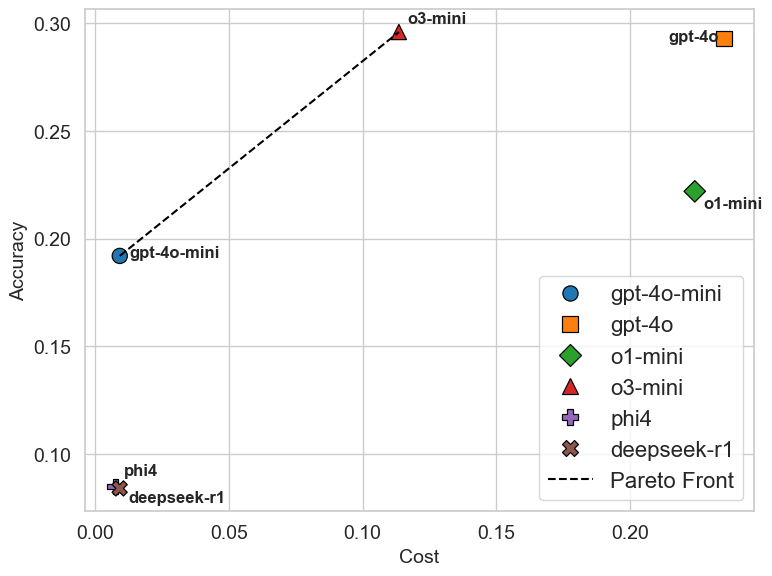

In [4]:
plot_cost_vs_accuracy_seaborn(results, save_path="cost_vs_accuracy.pdf")